# Visión por computadora II
## Trabajo Práctico Integrador

## Modelo


### Configuración de librerías

In [1]:
import os
import gc
import random
from time import time
from glob import glob
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from collections import Counter
import dill as pickle

from plotly import graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots


import cv2

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import fbeta_score, confusion_matrix

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as T, models
from torchvision.models.resnet import ResNet18_Weights
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR

from torchsummary import summary

from matplotlib import pyplot as plt
%matplotlib inline

from torch.utils.tensorboard import SummaryWriter

In [2]:
# Creamos el directorio de salida si no existe
path_output = "../output"
if not os.path.exists(path_output):
    os.makedirs(path_output)

In [3]:
# Crear el directorio de logs si no existe para guardar los logs de tensorboard
logs_dir = '../logs'
if not os.path.exists(logs_dir):
    os.makedirs(logs_dir)

In [4]:
# Si tenemos disponible GPU, lo usamos
# Chequeamos si tenemos disponible GPU (CUDA)
if torch.cuda.is_available():
    device = "cuda"
# Chequeamos si tenemos disponible aceleración por hardware en un chip de Apple (MPS)
elif torch.backends.mps.is_available():
    device = "mps"
# Por defecto usamos CPU
else:
    device = "cpu"

print(f"device: {device}")

device: cuda


In [5]:
# Semilla para reproducibilidad de los experimentos
random.seed(42)
np.random.seed(42)
torch.manual_seed(42);

### Cargamos los datasets preprocesados.

In [6]:
path = "../data"

# Path de las imágenes de entrenamiento Estan todas las imágenes, ya que quien define que 
# imagen pertenece a entrenamiento, validación o test es el archivo csv
path_train = os.path.join(path, "train") 
#path_test = os.path.join(path, "test") # Path de las imágenes de test. Que se descartaron
#path_valid = os.path.join(path, "valid") # Path de las imágenes de validación. Que se descartaron
print(
    f"train files: {len(os.listdir(path_train))}, "
    #f"test files: {len(os.listdir(path_test))}, "
    #f"valid files: {len(os.listdir(path_valid))}"
)

train files: 11466, 


> La suma de las imágenes de train, test y valid de los csv debe ser igual a la cantidad de imágenes en la carpeta train


In [7]:
# Cargamos el dataset de train
path_train_class = os.path.join(path, "train_dataset_preprocesado.csv")
df_train = pd.read_csv(path_train_class)
print(df_train.shape)
df_train.head()

(7340, 37)


,filename,Aerosols,Aluminum can,Cardboard,Cellulose,Ceramic,Container for household chemicals,Disposable tableware,Electronics,Furniture,...,Plastic toys,Postal packaging,Printing industry,Scrap metal,Stretch film,Tetra pack,Textile,Tin,Unknown plastic,Zip plastic bag
0,afe7846c-AluCan477_jpg.rf.a91f8c8b95877f244426...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,054a27ce-O_13607_jpg.rf.a9244c990c852cd6911168...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9c2713f8-R_817_jpg.rf.a9900435405fc7a9d162fb47...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4b0b9a15-R_3800_jpg.rf.a8f5db50ffd9a6bea52e4af...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,424468bb-R_7112_jpg.rf.a8fac30760693a9e0a8ce08...,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# Cargamos el dataset de test
path_test_class = os.path.join(path, "test_dataset_preprocesado.csv")
df_test = pd.read_csv(path_test_class)
print(df_test.shape)
df_test.head()

(2291, 37)


,filename,Aerosols,Aluminum can,Cardboard,Cellulose,Ceramic,Container for household chemicals,Disposable tableware,Electronics,Furniture,...,Plastic toys,Postal packaging,Printing industry,Scrap metal,Stretch film,Tetra pack,Textile,Tin,Unknown plastic,Zip plastic bag
0,2ccff6c6-AluCan257_jpg.rf.a8f53f21395d0d5757d7...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,59b34896-R_2091_jpg.rf.a967d601319609446bd2cd5...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,d254face-R_4159_jpg.rf.a95781333b43a5c8c62d42b...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,eb559464-O_13694_jpg.rf.a8ece945730b0647388b64...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0d43474a-R_1215_jpg.rf.a98e6508a5ea28fc11d6868...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# Cargamos el dataset de valid
path_valid_class = os.path.join(path, "val_dataset_preprocesado.csv")
df_valid = pd.read_csv(path_valid_class)
print(df_valid.shape)
df_valid.head()

(1835, 37)


,filename,Aerosols,Aluminum can,Cardboard,Cellulose,Ceramic,Container for household chemicals,Disposable tableware,Electronics,Furniture,...,Plastic toys,Postal packaging,Printing industry,Scrap metal,Stretch film,Tetra pack,Textile,Tin,Unknown plastic,Zip plastic bag
0,556a8099-AluCan636_jpg.rf.a9362b662c93c67114d2...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,adcadee3-R_1549_jpg.rf.a8fa5bad17a37fb7362f3ca...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,85d62b5a-AluCan19_jpg.rf.a902355ad7961331d1005...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,08584679-R_3707_jpg.rf.a9652f16485e5651c994e79...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,20693a7a-O_13938_jpg.rf.a9c3e6e30e354f3e643636...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Modelo

Para un rendimiento óptimo, resnet18 necesita una forma de entrada que sea múltiplo de 32 y en nuestro caso tenemos una entrada de tamaño 256. De 256, el múltiplo de 32 más cercano es 224.

Los valores mean y std utilizados en las transformaciones de normalización (mean=[0.485, 0.456, 0.406] y std=[0.229, 0.224, 0.225]) son estadísticas pre-calculadas sobre el conjunto de datos ImageNet. ImageNet es un gran conjunto de datos de imágenes comúnmente utilizado para entrenar modelos de visión por computadora, incluyendo redes neuronales profundas como ResNet.

Estos valores se utilizan para centrar los datos en torno a cero y escalar la varianza, lo cual puede ayudar a la red a entrenar más eficientemente. La idea es que al normalizar las imágenes con los mismos valores de mean y std con los que el modelo preentrenado fue entrenado, el rendimiento del modelo será mejor y más consistente.

In [10]:
def obtener_transforms():
    transform_train = T.Compose([
        T.ToPILImage(),
        T.Resize(224),
        T.ToTensor(),
        T.Normalize(
            mean=[0.485, 0.456, 0.406], # Media extraída de ImageNet
            std=[0.229, 0.224, 0.225], # Desviación estándar extraída de ImageNet
        )
    ])
    transform_val = T.Compose([
        T.ToPILImage(),
        T.Resize(224),
        T.ToTensor(),
        T.Normalize(
            mean=[0.485, 0.456, 0.406], # Media extraída de ImageNet
            std=[0.229, 0.224, 0.225], # Desviación estándar extraída de ImageNet
        )
    ])
    return transform_train, transform_val

Definimos la clase de dataset personalizado para manipular los batchs de datos entre RAM y disco más fácilmente. 

Algunos puntos importantes:

* `__init__`: Este es el constructor de la clase. Inicializa varias variables de instancia, incluyendo un DataFrame que contiene los datos, ohe_tags (etiquetas codificadas en one-hot), transform (una función de transformación para aplicar a las imágenes), path (la ruta o rutas a las imágenes), is_train (un booleano que indica si el conjunto de datos es para entrenamiento o prueba), y idx_tta (un índice para la técnica de aumento de test, [TTA](../referencias/TTA.md)). 

Es importante distinguir la fase de entrenamiento de la fase de prueba porque utilizamos el aumento de pruebas.
El aumento de pruebas (TTA) es útil para diversificar nuestro conjunto de datos de entrenamiento y construir un modelo más sólido. Se aplica a cada imagen para cada lote, lo que significa que no aumenta la longitud de nuestro conjunto de datos de entrenamiento, pero transforma cada imagen aleatoriamente durante el tiempo de ejecución.

* `__len__`: Este método devuelve la longitud del DataFrame, es decir, el número de elementos en el conjunto de datos.

* `__getitem__`: Este método se utiliza para obtener un elemento del conjunto de datos dado un índice. Lee la imagen correspondiente del disco, la convierte de BGR a RGB, y devuelve la imagen y su etiqueta correspondiente.

* `collate_fn`: Este método se utiliza para procesar un lote de imágenes y etiquetas. Aplica la función de transformación a cada imagen, las convierte en tensores, las permuta, y las apila en un tensor de mayor dimensión.

* `load_img`: Este método carga una imagen y su etiqueta correspondiente del conjunto de datos y las muestra en una gráfica.

* `custom_augment`: Este método aplica una serie de transformaciones a una imagen, incluyendo rotaciones y volteos. Las transformaciones son aleatorias durante el entrenamiento y no aleatorias durante las pruebas para la TTA.


In [11]:
class YoloWasteDatasetError(Exception):
    pass

class YoloWasteDataset(Dataset):
    def __init__(self, df, ohe_tags, transform, path, is_train=True, idx_tta=None):
        super().__init__()
        self.df = df
        self.ohe_tags = ohe_tags
        self.transform = transform
        if isinstance(path, str):
            self.paths = [path]
        elif isinstance(path, (list, tuple)):
            self.paths = path
        else:
            raise YoloWasteDatasetError(f"Path type must be str, list or tuple, got: {type(path)}")
        self.is_train = is_train
        if not is_train:
            if not idx_tta in list(range(6)):
                raise YoloWasteDatasetError(
                    f"In test mode, 'idx_tta' must be an int belonging to [0, 5], got: {repr(idx_tta)}"
                )
            self.idx_tta = idx_tta

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        filename = self.df.iloc[idx, 0] # Asumiendo que la primer columna es filename
        for path in self.paths:
            if filename in os.listdir(path):
                file_path = os.path.join(path, filename)
                break
        else:
            raise YoloWasteDatasetError(f"Can't fetch {filename} among {self.paths}")
        img = cv2.imread(file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label = self.ohe_tags[idx]
        return img, label

    def collate_fn(self, batch):
        imgs, labels = [], []
        for (img, label) in batch:
            img = self.custom_augment(img)
            img = torch.tensor(img)
            img = img.permute(2, 0, 1)
            img = self.transform(img)
            imgs.append(img[None])
            labels.append(label)
        imgs = torch.cat(imgs).float().to(device)
        labels = torch.tensor(labels).float().to(device)
        return imgs, labels

    def load_img(self, idx, ax=None):
        img, ohe_label = self[idx]
        label = self.df.iloc[idx]
        title = f"{label} - {ohe_label}"
        if ax is None:
            plt.imshow(img)
            plt.title(title)
        else:
            ax.imshow(img)
            ax.set_title(title)
    
    def custom_augment(self, img):
        """
        Discrete rotation and horizontal flip.
        Random during training and non random during testing for TTA.
        Not implemented in torchvision.transforms, hence this function.
        """
        choice = np.random.randint(0, 6) if self.is_train else self.idx_tta
        if choice == 0:
            # Rotar 90 grados
            img = cv2.rotate(img, rotateCode=cv2.ROTATE_90_CLOCKWISE)
        if choice == 1:
            # Rotar 90 grados y voltear horizontalmente
            img = cv2.rotate(img, rotateCode=cv2.ROTATE_90_CLOCKWISE)
            img = cv2.flip(img, flipCode=1)
        if choice == 2:
            # Rotar 180 grados
            img = cv2.rotate(img, rotateCode=cv2.ROTATE_180)
        if choice == 3:
            # Rotar 180 grados y voltear horizontalmente
            img = cv2.rotate(img, rotateCode=cv2.ROTATE_180)
            img = cv2.flip(img, flipCode=1)
        if choice == 4:
            # Rotar 90 grados en sentido antihorario
            img = cv2.rotate(img, rotateCode=cv2.ROTATE_90_COUNTERCLOCKWISE)
        if choice == 5:
            # Rotar 90 grados en sentido antihorario y voltear horizontalmente
            img = cv2.rotate(img, rotateCode=cv2.ROTATE_90_COUNTERCLOCKWISE)
            img = cv2.flip(img, flipCode=1)
        return img

In [12]:
def get_data(df_train, df_val, df_test, path_train, batch_size):
    # Suponiendo que la primera columna es el nombre del archivo y el resto son las columnas de categoría
    category_columns = df_train.columns[1:]

    # Extraemos las etiquetas directamente del dataframe.
    ohe_tags_train = df_train[category_columns].values
    ohe_tags_val = df_val[category_columns].values
    ohe_tags_test = df_test[category_columns].values

    # Obtén las transformaciones
    transform_train, transform_val = obtener_transforms()

    # Crear datasets
    ds_train = YoloWasteDataset(df_train, ohe_tags_train, transform_train, path=path_train)
    ds_val = YoloWasteDataset(df_val, ohe_tags_val, transform_val, path=path_train)
    ds_test = YoloWasteDataset(df_test, ohe_tags_test, transform_val, path=path_train)

    # Crear dataloaders
    dl_train = DataLoader(
        ds_train,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=ds_train.collate_fn
    )
    dl_val = DataLoader(
        ds_val,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=ds_val.collate_fn
    )
    dl_test = DataLoader(
        ds_test,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=ds_test.collate_fn
    )

    return ds_train, ds_val, ds_test, dl_train, dl_val, dl_test

# Ejemplo de uso
# df_train = pd.read_csv('train.csv')
# df_val = pd.read_csv('val.csv')
# df_test = pd.read_csv('test.csv')
# path_train = 'path/to/train/images'
# ds_train, ds_val, ds_test, dl_train, dl_val, dl_test = get_data(df_train, df_val, df_test, path_train)


In [13]:
#ds_train, ds_val, dl_train, dl_val = get_data(df_train, df_valid, path_train)
ds_train, ds_val, ds_test, dl_train, dl_val, dl_test = get_data(df_train, df_valid, df_test, path_train, batch_size=64)

In [14]:
imgs, labels = next(iter(dl_train))
imgs.shape, labels.shape

/tmp/ipykernel_59491/2880513708.py:50: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  labels = torch.tensor(labels).float().to(device)


(torch.Size([64, 3, 224, 224]), torch.Size([64, 36]))

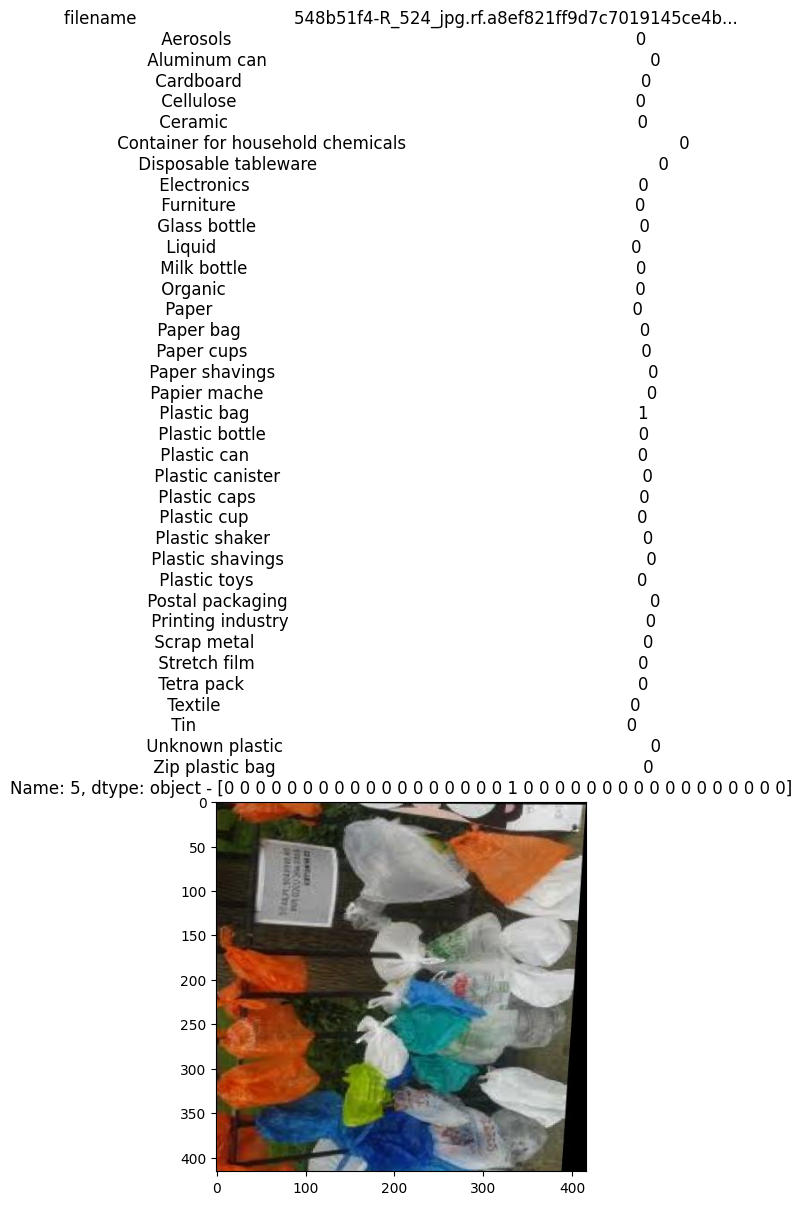

In [15]:
ds_train.load_img(5)

### Definición de los modelos

Descargamos pesos directamente del resnet18 previamente entrenado y congelamos todos los pesos. Sobrescribimos la última capa completamente conectada agregando dos capas densas seguidas de un sigmoide. Esta última parte del fc es la única capa a entrenar.

In [16]:
# Resnet18
def get_resnet_model():
    weights = ResNet18_Weights.DEFAULT
    model = models.resnet18(weights=weights)
    for param in model.parameters():
        param.require_grad = False
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
    model.fc = nn.Sequential(
      nn.Flatten(),
      nn.Linear(512, 128),
      nn.ReLU(inplace=True),
      nn.Dropout(.2),
      nn.Linear(128, 36),
      nn.Sigmoid()
    )

    return model.to(device)

Ahora descargamos EfficientNet-B0 previamente entrenado y congelamos todos los pesos. Descongelamos las ultimas capas. Y modificamos la capa final completamente conectada agregando dos capas densas seguidas de un sigmoide. Esta última parte del fc es la única capa a entrenar.

In [17]:
# EfficientNet-B0
def get_efficientnet_model():
    weights = models.EfficientNet_B0_Weights.DEFAULT
    model = models.efficientnet_b0(weights=weights)
    
    for param in model.parameters():
        param.requires_grad = False
    
    for param in model.features[-1].parameters():
        param.requires_grad = True
    
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2, inplace=True),
        nn.Linear(model.classifier[1].in_features, 128),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.2),
        nn.Linear(128, 36),
        nn.Sigmoid()
    )

    return model.to(device)

Ahora descargamos Vision Transformer (ViT)

In [18]:
# Vision Transformers ViT
def get_vit_model():
    #TODO: Implementar el modelo Vision Transformer (ViT)
    pass

Ahora descargamos Swin Transformers

In [19]:
def get_swin_transformer_model():
    #TODO: Implementar el modelo Swin Transformer
    pass

### Entrenamiento

In [20]:
def train_batch(X, Y, model, loss_fn, optimizer):
    model.train()
    optimizer.zero_grad()
    Y_hat = model(X)
    batch_loss = loss_fn(Y_hat, Y)
    batch_loss.backward()
    optimizer.step()
    Y_hat = Y_hat.detach().float().cpu().numpy()
    
    return Y_hat, batch_loss.item()


@torch.no_grad()
def compute_val_loss(X, Y, model, loss_fn):
    model.eval()
    Y_hat = model(X)
    batch_loss = loss_fn(Y_hat, Y)
    Y_hat = Y_hat.detach().float().cpu().numpy()
    
    return Y_hat, batch_loss.item()

Elegimos configurar por defecto nuestro modelo durante 15 épocas, mientras reducimos nuestra tasa de aprendizaje 10 veces cada 7 lotes. Monitoreamos que la pérdida de validación son nuestras métricas clave. La puntuación de validación es útil sólo como indicación secundaria, porque elegimos el umbral de clasificación de forma bastante aleatoria (0,2).
Posteriormente encontraremos el umbral más adecuado para cada objetivo.

Mas adelante efectuamos una optimización de hiperparámetros usando algoritmos genéticos. (Falta referencias)

La métrica de evaluación será f1-beta. Revisamos varias: [Métricas](../referencias/Metricas_Evaluacion.md)
 - Es una generalización del F1-score que permite ajustar el equilibrio entre Precision y Recall mediante un parámetro beta \( $\beta$ \). Un valor de \( $\beta$ > 1 \) da más peso a Recall y \( $\beta$ < 1 \) da más peso a Precision.

- \[ $\text{F1-}\beta = (1 + \beta^2) \cdot \frac{\text{Precision} \cdot \text{Recall}}{(\beta^2 \cdot \text{Precision}) + \text{Recall}}$ \]

In [21]:
def train_model(dl_train, dl_val, idx_fold, model, optimizer, loss_fn, model_name, epochs=15):

    writer = SummaryWriter(log_dir=f'{logs_dir}/{model_name}_fold{idx_fold}') # Para tensorboard
    lr_scheduler = StepLR(optimizer, step_size=7, gamma=0.1) # Reduce el learning rate por 10 cada 7 epochs

    loss_train, loss_val = [], []
    score_train, score_val = [], []

    Y_hat_val = None
    Y_thresh_val = None  # Inicializar con None para evitar errores
    best_loss_val = np.inf

    for idx in range(epochs):
        loss_train_epoch, loss_val_epoch = [], []
        Y_hat_train_epoch, Y_hat_val_epoch = [], []
        Y_train_epoch, Y_val_epoch = [], []

        for X, Y in tqdm(dl_train, leave=False):
            Y_hat, batch_loss = train_batch(X, Y, model, loss_fn, optimizer)
            loss_train_epoch.append(batch_loss)
            Y_hat_train_epoch.extend(Y_hat)
            Y_train_epoch.extend(Y.detach().float().cpu().numpy())

        for X, Y in tqdm(dl_val, leave=False):
            Y_hat, batch_loss = compute_val_loss(X, Y, model, loss_fn)
            loss_val_epoch.append(batch_loss)
            Y_hat_val_epoch.extend(Y_hat)
            Y_val_epoch.extend(Y.detach().float().cpu().numpy())
                
        avg_loss_train = np.mean(loss_train_epoch)
        avg_loss_val = np.mean(loss_val_epoch)

        Y_hat_train_epoch = np.array(Y_hat_train_epoch)
        Y_hat_val_epoch = np.array(Y_hat_val_epoch)
        Y_thresh_train_epoch = (Y_hat_train_epoch > .2).astype(float)
        Y_thresh_val_epoch = (Y_hat_val_epoch > .2).astype(float)
        Y_train_epoch = np.array(Y_train_epoch)
        Y_val_epoch = np.array(Y_val_epoch)
        
        score_train_epoch = fbeta_score(Y_train_epoch, Y_thresh_train_epoch, beta=2, average="samples")
        score_val_epoch = fbeta_score(Y_val_epoch, Y_thresh_val_epoch, beta=2, average="samples")
        
               
        # saving values for debugging
        if avg_loss_val < best_loss_val:
            best_loss_val = avg_loss_val
            Y_hat_val = Y_hat_val_epoch
            Y_thresh_val = Y_thresh_val_epoch
            Y_val = Y_val_epoch
            
        loss_train.append(avg_loss_train)
        loss_val.append(avg_loss_val)
        score_train.append(score_train_epoch)
        score_val.append(score_val_epoch)

        print(
            f"epoch: {idx}/{epochs} -- train loss: {avg_loss_train}, " \
            f"val loss: {avg_loss_val}" \
            f" -- train fbeta_score: {score_train_epoch}, " \
            f"val fbeta_score: {score_val_epoch}"
        )

        # Guardar los valores en tensorboard
        writer.add_scalar('Loss/train', avg_loss_train, idx)
        writer.add_scalar('Loss/val', avg_loss_val, idx)
        writer.add_scalar('Score/train', score_train_epoch, idx)
        writer.add_scalar('Score/val', score_val_epoch, idx)
        
        lr_scheduler.step()


    writer.close() # Cerrar tensorboard

    train_results = {
        "loss_train": loss_train,
        "loss_val": loss_val,
        "score_train": score_train,
        "score_val": score_val,
        "Y_hat_val": Y_hat_val,
        "Y_thresh_val": Y_thresh_val,
        "Y_val": Y_val,
    }
        
    
    # Guardamos el modelo
    torch.save(model, os.path.join(path_output, f"{model_name}_fold{idx_fold}.pth"))

    # Guardar los resultados del entrenamiento
    pickle.dump(train_results, open(f"../output/train_results_{model_name}_fold{idx_fold}.pkl", "wb"))
    

### Búsqueda de mejores hiperparametros

Realizamos la búsqueda de mejores hiperparámetros empleando Random Search.

Intentamos previamente la búsqueda de mejores hiperparámetros empleando la librería DEAP (Distributed Evolutionary Algorithms in Python). Pero la mutación generaba valores anómalos del learning rate. Así que decidimos emplear Random Search.


In [22]:
# Define los límites de los hiperparámetros
LIMITES = {
    "lr": (1e-4, 2e-2),
    "batch_size": [16, 32, 64],
    "num_epochs": [5, 10, 15]
}

In [21]:
# Mapa de arquitecturas
model_map = {
    "resnet18": get_resnet_model,
    "efficientnet_b0": get_efficientnet_model,
    # "vit": get_vit_model,
    # "swin_transformer": get_swin_transformer_model
}

In [24]:
# Función para realizar Random Search
def random_search(model_name, n_iter=15):
    best_score = -np.inf
    best_params = None

    for _ in range(n_iter):
        lr = random.uniform(*LIMITES["lr"])
        batch_size = random.choice(LIMITES["batch_size"])
        num_epochs = random.choice(LIMITES["num_epochs"])

        ds_train, ds_val, ds_test, dl_train, dl_val, dl_test = get_data(df_train, df_valid, df_test, path_train, batch_size)

        model_fn = model_map[model_name]
        model = model_fn()
        optimizer = Adam(model.parameters(), lr=lr)
        loss_fn = nn.BCELoss()

        print("_____________________________________________________________________________________________")
        print(f"Parámetros de optimización => lr: {lr}, batch_size: {batch_size}, num_epochs: {num_epochs}")
        print("_____________________________________________________________________________________________")

        train_model(dl_train, dl_val, 0, model, optimizer, loss_fn, model_name, epochs=num_epochs)

        train_results = pickle.load(open(f"../output/train_results_{model_name}_fold0.pkl", "rb"))
        score_val = max(train_results["score_val"])

        if score_val > best_score:
            best_score = score_val
            best_params = (lr, batch_size, num_epochs)

    print("\n")
    print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    print(f"Mejores parámetros encontrados => lr: {best_params[0]}, batch_size: {best_params[1]}, num_epochs: {best_params[2]}")
    return best_params


In [22]:
%load_ext tensorboard
%tensorboard --logdir=../logs --host 0.0.0.0 --port 6006

#### Al abrir en el navegador http://localhost:6006 veremos la evolución del entrenamiento.

In [26]:
# Ejecutamos la optimización para cada modelo
#model_names = ["resnet18", "efficientnet_b0", "vit", "swin_transformer"]
model_names = ["resnet18", "efficientnet_b0"]
for model_name in model_names:
    print("\n")
    print(f"Optimizando modelo: {model_name}")
    best_params = random_search(model_name, n_iter=15)
        
    lr, batch_size, num_epochs = best_params
        
    ds_train, ds_val, ds_test, dl_train, dl_val, dl_test = get_data(df_train, df_valid, df_test, path_train, batch_size)

    model_fn = model_map[model_name]
    model = model_fn()
    optimizer = Adam(model.parameters(), lr=lr)
    loss_fn = nn.BCELoss()

    print("\n") 
    print("===========================================================================================")
    print(f"Entrenando el mejor modelo con lr={lr}, batch_size={batch_size}, num_epochs={num_epochs}")
    print("===========================================================================================")
    train_model(dl_train, dl_val, 1, model, optimizer, loss_fn, model_name, epochs=num_epochs)

    Y_hat_test, Y_test = [], []
    for X, Y in tqdm(dl_test, leave=False):
        Y_hat, _ = compute_val_loss(X, Y, model, loss_fn)
        Y_hat_test.extend(Y_hat)
        Y_test.extend(Y.detach().float().cpu().numpy())
        
    Y_hat_test = np.array(Y_hat_test)
    Y_test = np.array(Y_test)
    Y_thresh_test = (Y_hat_test > .2).astype(float)
        
    final_score = fbeta_score(Y_test, Y_thresh_test, beta=2, average="samples")
    print("\n")
    print("*************************************************************************************")
    print(f"* Puntaje final de Fbeta en el conjunto de pruebas para {model_name}: {final_score}  *")
    print("**************************************************************************************")

# Con 5 iteraciones, el tiempo de ejecución es de aproximadamente 131 minutos 8.1 segundos.
# Con 15 iteraciones, el tiempo de ejecución es de aproximadamente 359 minutos 48.1 segundos.



Optimizando modelo: resnet18
_____________________________________________________________________________________________
Parámetros de optimización => lr: 0.0005977140289310721, batch_size: 32, num_epochs: 5
_____________________________________________________________________________________________


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 0/5 -- train loss: 0.07673952887239663, val loss: 0.04568721556329522 -- train fbeta_score: 0.6288317756079368, val fbeta_score: 0.7233770165650275


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 1/5 -- train loss: 0.03985199554944816, val loss: 0.033786982153381766 -- train fbeta_score: 0.7809445625521919, val fbeta_score: 0.8042448922557913


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 2/5 -- train loss: 0.03307555848327668, val loss: 0.03714789832332011 -- train fbeta_score: 0.8269992432768919, val fbeta_score: 0.7930409584360537


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 3/5 -- train loss: 0.029042740548839388, val loss: 0.03717607749497582 -- train fbeta_score: 0.8485026603865761, val fbeta_score: 0.793378314086761


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 4/5 -- train loss: 0.025489382798095112, val loss: 0.027743501412072057 -- train fbeta_score: 0.8719137809306506, val fbeta_score: 0.8432829961440317
_____________________________________________________________________________________________
Parámetros de optimización => lr: 0.004541893689161573, batch_size: 64, num_epochs: 5
_____________________________________________________________________________________________


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 0/5 -- train loss: 0.10313037342351417, val loss: 0.08580225115192347 -- train fbeta_score: 0.29299127853183404, val fbeta_score: 0.39969095391438714


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 1/5 -- train loss: 0.09619954659239105, val loss: 0.07817213031752356 -- train fbeta_score: 0.3583355034308712, val fbeta_score: 0.4030664763634791


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 2/5 -- train loss: 0.07475885868720386, val loss: 0.06862972252841654 -- train fbeta_score: 0.4517328058710893, val fbeta_score: 0.4533151680290646


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 3/5 -- train loss: 0.07058087357360383, val loss: 0.07096757701244848 -- train fbeta_score: 0.4981505662328048, val fbeta_score: 0.5127978893646469


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 4/5 -- train loss: 0.06772166289713072, val loss: 0.09873980797570327 -- train fbeta_score: 0.5329573935129713, val fbeta_score: 0.43572077332295317
_____________________________________________________________________________________________
Parámetros de optimización => lr: 0.013566319799715934, batch_size: 64, num_epochs: 5
_____________________________________________________________________________________________


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 0/5 -- train loss: 0.11375988371994185, val loss: 0.0892830565571785 -- train fbeta_score: 0.24375448378984077, val fbeta_score: 0.291516204050264


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 1/5 -- train loss: 0.08377163215823795, val loss: 0.07883158814290474 -- train fbeta_score: 0.3237870754870675, val fbeta_score: 0.3359173977702588


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 2/5 -- train loss: 0.07923816520234812, val loss: 0.07434574463244142 -- train fbeta_score: 0.37466966314037153, val fbeta_score: 0.3808938261254337


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 3/5 -- train loss: 0.07813288971133854, val loss: 0.07908615290090956 -- train fbeta_score: 0.39552677681083676, val fbeta_score: 0.3769473638683448


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 4/5 -- train loss: 0.07517226604015931, val loss: 0.07186813652515411 -- train fbeta_score: 0.43789542277280696, val fbeta_score: 0.43052203624410706
_____________________________________________________________________________________________
Parámetros de optimización => lr: 0.011850800997735889, batch_size: 16, num_epochs: 5
_____________________________________________________________________________________________


  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

epoch: 0/5 -- train loss: 0.11756917738511931, val loss: 0.0932060040857481 -- train fbeta_score: 0.21574972295340142, val fbeta_score: 0.176566757493188


  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

epoch: 1/5 -- train loss: 0.08900194511239565, val loss: 0.0863419604042302 -- train fbeta_score: 0.23462544872626617, val fbeta_score: 0.25461701483499843


  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

epoch: 2/5 -- train loss: 0.08380430806955741, val loss: 0.5673184606044189 -- train fbeta_score: 0.3109446449705306, val fbeta_score: 0.34182977180252383


  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

epoch: 3/5 -- train loss: 0.07954506938850958, val loss: 0.07347269333575084 -- train fbeta_score: 0.3940465377795078, val fbeta_score: 0.39635596011617813


  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

epoch: 4/5 -- train loss: 0.07767512925245144, val loss: 0.07038484377705533 -- train fbeta_score: 0.4135847652196426, val fbeta_score: 0.46706457333160334
_____________________________________________________________________________________________
Parámetros de optimización => lr: 0.00196453527324569, batch_size: 16, num_epochs: 15
_____________________________________________________________________________________________


  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

epoch: 0/15 -- train loss: 0.0896863845828312, val loss: 0.08051149300906969 -- train fbeta_score: 0.37121667374297523, val fbeta_score: 0.39962804376973315


  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

epoch: 1/15 -- train loss: 0.07572479544446879, val loss: 0.07137029579152232 -- train fbeta_score: 0.4740548628656699, val fbeta_score: 0.486631201072618


  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

epoch: 2/15 -- train loss: 0.0715387517785195, val loss: 0.07151194554956063 -- train fbeta_score: 0.5226702824254515, val fbeta_score: 0.5199504779205052


  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

epoch: 3/15 -- train loss: 0.06869758816521152, val loss: 0.06297159408745559 -- train fbeta_score: 0.5502600588100014, val fbeta_score: 0.5505557718091778


  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

epoch: 4/15 -- train loss: 0.06731316709408054, val loss: 0.06197512885150702 -- train fbeta_score: 0.5617837657347194, val fbeta_score: 0.5736084079408329


  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

epoch: 5/15 -- train loss: 0.06440937377447527, val loss: 0.062348557393188064 -- train fbeta_score: 0.5903283122173368, val fbeta_score: 0.5830240906535185


  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

epoch: 6/15 -- train loss: 0.06291146563824615, val loss: 0.06079047035587871 -- train fbeta_score: 0.5951124545300295, val fbeta_score: 0.5991393105834522


  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

epoch: 7/15 -- train loss: 0.05528012442773853, val loss: 0.05078272851912872 -- train fbeta_score: 0.6493295273718819, val fbeta_score: 0.6737068033389559


  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

epoch: 8/15 -- train loss: 0.052024462903506874, val loss: 0.04858096698703973 -- train fbeta_score: 0.6704590204189499, val fbeta_score: 0.6872076152730103


  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

epoch: 9/15 -- train loss: 0.05105521296575049, val loss: 0.04868210178354512 -- train fbeta_score: 0.6803732584667029, val fbeta_score: 0.6790017732797025


  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

epoch: 10/15 -- train loss: 0.0507472031272964, val loss: 0.04677013390414093 -- train fbeta_score: 0.679649605327799, val fbeta_score: 0.7027031702781023


  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

epoch: 11/15 -- train loss: 0.0488354730133722, val loss: 0.04712177119825197 -- train fbeta_score: 0.6954594998953069, val fbeta_score: 0.6993771895679252


  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

epoch: 12/15 -- train loss: 0.04848940490312826, val loss: 0.045191825683350145 -- train fbeta_score: 0.6970680551172216, val fbeta_score: 0.7172008131136197


  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

epoch: 13/15 -- train loss: 0.04693660721353261, val loss: 0.04631660585494145 -- train fbeta_score: 0.710534837351034, val fbeta_score: 0.7059372431988237


  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

epoch: 14/15 -- train loss: 0.044857899071993654, val loss: 0.04383650741985311 -- train fbeta_score: 0.7192827727338467, val fbeta_score: 0.7165131265948705
_____________________________________________________________________________________________
Parámetros de optimización => lr: 0.012080172708094609, batch_size: 64, num_epochs: 5
_____________________________________________________________________________________________


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 0/5 -- train loss: 0.13784693414750307, val loss: 0.09032472685493272 -- train fbeta_score: 0.23609724866236328, val fbeta_score: 0.30526793823796544


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 1/5 -- train loss: 0.08845531292583632, val loss: 0.08018757839655054 -- train fbeta_score: 0.29691230336065244, val fbeta_score: 0.3462566497988841


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 2/5 -- train loss: 0.08160761886316797, val loss: 0.07812543239059119 -- train fbeta_score: 0.3751576039306392, val fbeta_score: 0.3749036007891594


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 3/5 -- train loss: 0.07844799578837726, val loss: 0.07995684085221126 -- train fbeta_score: 0.3975331066526571, val fbeta_score: 0.3660784568141517


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 4/5 -- train loss: 0.07671325695903405, val loss: 0.07848175640763908 -- train fbeta_score: 0.41729460367062554, val fbeta_score: 0.3764802560442887
_____________________________________________________________________________________________
Parámetros de optimización => lr: 0.01434879029715583, batch_size: 64, num_epochs: 15
_____________________________________________________________________________________________


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 0/15 -- train loss: 0.11644920305065487, val loss: 0.08428247889568066 -- train fbeta_score: 0.24397492322640585, val fbeta_score: 0.2471389645776567


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 1/15 -- train loss: 0.08260424234296965, val loss: 0.0795180874651876 -- train fbeta_score: 0.3343265026677833, val fbeta_score: 0.3009082652134424


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 2/15 -- train loss: 0.0808719532645267, val loss: 0.0799552140564754 -- train fbeta_score: 0.35569984624821144, val fbeta_score: 0.3646814584144284


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 3/15 -- train loss: 0.08065069596404614, val loss: 0.07701947360203185 -- train fbeta_score: 0.3587574853242428, val fbeta_score: 0.3518878941222266


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 4/15 -- train loss: 0.0787595144432524, val loss: 0.07551901684752826 -- train fbeta_score: 0.38807459570402353, val fbeta_score: 0.4054020154837594


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 5/15 -- train loss: 0.07597281336784363, val loss: 0.07481093473475554 -- train fbeta_score: 0.4150358686121629, val fbeta_score: 0.3953029713247697


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 6/15 -- train loss: 0.07434230488927468, val loss: 0.0740297931278574 -- train fbeta_score: 0.44240093589248103, val fbeta_score: 0.3971238268240993


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 7/15 -- train loss: 0.07012596389521723, val loss: 0.06737304658725343 -- train fbeta_score: 0.47592399274960584, val fbeta_score: 0.4858224125254098


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 8/15 -- train loss: 0.0687575500620448, val loss: 0.06718939427157929 -- train fbeta_score: 0.4973965842664753, val fbeta_score: 0.4952207949483154


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 9/15 -- train loss: 0.06781743742201639, val loss: 0.06545841218582515 -- train fbeta_score: 0.5116703384414556, val fbeta_score: 0.5128757406686562


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 10/15 -- train loss: 0.06718244721060214, val loss: 0.0647481622110153 -- train fbeta_score: 0.5180643921758283, val fbeta_score: 0.5188270403529259


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 11/15 -- train loss: 0.06628139488722967, val loss: 0.06410075505745821 -- train fbeta_score: 0.5305369256974082, val fbeta_score: 0.5306042126205615


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 12/15 -- train loss: 0.06567666388076285, val loss: 0.0630820317771928 -- train fbeta_score: 0.5366426815957991, val fbeta_score: 0.5491241728298949


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 13/15 -- train loss: 0.06474851198170496, val loss: 0.06295802097382217 -- train fbeta_score: 0.549663953053814, val fbeta_score: 0.5438129838674798


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 14/15 -- train loss: 0.06365223656529966, val loss: 0.06110093138855079 -- train fbeta_score: 0.5619986746659691, val fbeta_score: 0.5672332511569569
_____________________________________________________________________________________________
Parámetros de optimización => lr: 0.008448444437137008, batch_size: 32, num_epochs: 15
_____________________________________________________________________________________________


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 0/15 -- train loss: 0.10602363704339318, val loss: 0.0878524692921803 -- train fbeta_score: 0.27672342783839016, val fbeta_score: 0.3375113533151681


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 1/15 -- train loss: 0.08490245549575143, val loss: 0.08193143572786758 -- train fbeta_score: 0.324041037426596, val fbeta_score: 0.3469636327946955


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 2/15 -- train loss: 0.0810704305768013, val loss: 0.07687058479621492 -- train fbeta_score: 0.3766224257879572, val fbeta_score: 0.38512175078932576


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 3/15 -- train loss: 0.07922113262440847, val loss: 0.07746096231557172 -- train fbeta_score: 0.39843998341954745, val fbeta_score: 0.43537909259980107


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 4/15 -- train loss: 0.07685158895733564, val loss: 0.07433971319476078 -- train fbeta_score: 0.42802537872360763, val fbeta_score: 0.4147074088490982


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 5/15 -- train loss: 0.07468996367052845, val loss: 0.0710290628003663 -- train fbeta_score: 0.45813387150240015, val fbeta_score: 0.46475498464599285


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 6/15 -- train loss: 0.07310288739593132, val loss: 0.06874421605005346 -- train fbeta_score: 0.4738331125562653, val fbeta_score: 0.4281259461095973


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 7/15 -- train loss: 0.06854514147600402, val loss: 0.06605306062205084 -- train fbeta_score: 0.4991112467611105, val fbeta_score: 0.5126441829439105


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 8/15 -- train loss: 0.06737528603685938, val loss: 0.06445467658340931 -- train fbeta_score: 0.520874008095518, val fbeta_score: 0.5356515721638337


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 9/15 -- train loss: 0.06622602975238924, val loss: 0.06276463415345242 -- train fbeta_score: 0.5385003021422067, val fbeta_score: 0.56096189611176


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 10/15 -- train loss: 0.06523438134919042, val loss: 0.061486657580425 -- train fbeta_score: 0.5523351994170635, val fbeta_score: 0.5625318974092817


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 11/15 -- train loss: 0.06413479904117791, val loss: 0.060379444428815925 -- train fbeta_score: 0.5618417610243223, val fbeta_score: 0.5765451321309633


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 12/15 -- train loss: 0.06251248051614865, val loss: 0.060965614650270034 -- train fbeta_score: 0.5753181681455443, val fbeta_score: 0.5741490419964534


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 13/15 -- train loss: 0.061938248169810875, val loss: 0.0597991901610432 -- train fbeta_score: 0.5827565624167643, val fbeta_score: 0.5844081138359069


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 14/15 -- train loss: 0.05967444129612135, val loss: 0.05663544577064699 -- train fbeta_score: 0.5976775098198804, val fbeta_score: 0.6033389559275117
_____________________________________________________________________________________________
Parámetros de optimización => lr: 0.005635995093790189, batch_size: 16, num_epochs: 5
_____________________________________________________________________________________________


  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

epoch: 0/5 -- train loss: 0.09559132584039942, val loss: 0.08664344432561294 -- train fbeta_score: 0.28232092805522896, val fbeta_score: 0.3703721724838891


  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

epoch: 1/5 -- train loss: 0.08608070903808722, val loss: 0.08238641665033672 -- train fbeta_score: 0.31957305674948727, val fbeta_score: 0.3271245254896481


  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

epoch: 2/5 -- train loss: 0.0821782574301062, val loss: 0.08275155953091123 -- train fbeta_score: 0.3786976893073623, val fbeta_score: 0.3907766166621753


  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

epoch: 3/5 -- train loss: 0.0780147078298925, val loss: 0.08637594431638718 -- train fbeta_score: 0.43847319044866734, val fbeta_score: 0.4961734904514196


  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

epoch: 4/5 -- train loss: 0.07479123130018675, val loss: 0.08023045727092287 -- train fbeta_score: 0.4687094744626, val fbeta_score: 0.49562069780053436
_____________________________________________________________________________________________
Parámetros de optimización => lr: 0.013992973960265715, batch_size: 32, num_epochs: 10
_____________________________________________________________________________________________


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 0/10 -- train loss: 0.1356077318282231, val loss: 0.0947338833377279 -- train fbeta_score: 0.23297672811166562, val fbeta_score: 0.29483586350071367


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 1/10 -- train loss: 0.08576002853072208, val loss: 0.08198849779778514 -- train fbeta_score: 0.3271439410574288, val fbeta_score: 0.3904675403313006


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 2/10 -- train loss: 0.08181992615370647, val loss: 0.08607282508806936 -- train fbeta_score: 0.3687439398836458, val fbeta_score: 0.3615501059642749


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 3/10 -- train loss: 0.07947008663221546, val loss: 0.07556220240377147 -- train fbeta_score: 0.3951870348979261, val fbeta_score: 0.4363652091172527


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 4/10 -- train loss: 0.0774068381799304, val loss: 0.07816561176602183 -- train fbeta_score: 0.42418021663293337, val fbeta_score: 0.4074261493880023


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 5/10 -- train loss: 0.0740410122372534, val loss: 0.07505225602152019 -- train fbeta_score: 0.46233855890952386, val fbeta_score: 0.4326888975390338


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 6/10 -- train loss: 0.07152161820103294, val loss: 0.07118801811131938 -- train fbeta_score: 0.4988210118940204, val fbeta_score: 0.501688774440818


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 7/10 -- train loss: 0.06682765156678531, val loss: 0.06396484811758173 -- train fbeta_score: 0.5403206226082383, val fbeta_score: 0.5448313720793285


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 8/10 -- train loss: 0.06573860156147376, val loss: 0.06279207926628919 -- train fbeta_score: 0.552192071943835, val fbeta_score: 0.5600882314778772


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 9/10 -- train loss: 0.06422155442769113, val loss: 0.0627501008967901 -- train fbeta_score: 0.5594289358083636, val fbeta_score: 0.5594956965529172
_____________________________________________________________________________________________
Parámetros de optimización => lr: 0.0031940420462544528, batch_size: 32, num_epochs: 5
_____________________________________________________________________________________________


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 0/5 -- train loss: 0.09283217956190525, val loss: 0.07579499740025093 -- train fbeta_score: 0.32594813096720593, val fbeta_score: 0.38413330538671137


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 1/5 -- train loss: 0.07554528293726237, val loss: 0.07205255278225603 -- train fbeta_score: 0.44880165874805916, val fbeta_score: 0.49445643669076916


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 2/5 -- train loss: 0.07203007918661056, val loss: 0.06857760950666049 -- train fbeta_score: 0.5016884297337896, val fbeta_score: 0.4900696336663639


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 3/5 -- train loss: 0.06954089840469153, val loss: 0.07338707662861922 -- train fbeta_score: 0.5262027532092848, val fbeta_score: 0.5112668137191297


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 4/5 -- train loss: 0.0672594973574514, val loss: 0.06541916535332284 -- train fbeta_score: 0.5529372180926813, val fbeta_score: 0.5495437048570564
_____________________________________________________________________________________________
Parámetros de optimización => lr: 0.0019456422832649434, batch_size: 16, num_epochs: 10
_____________________________________________________________________________________________


  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

epoch: 0/10 -- train loss: 0.09156596314056506, val loss: 0.07387989795078402 -- train fbeta_score: 0.3575159050548735, val fbeta_score: 0.47032567795510577


  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

epoch: 1/10 -- train loss: 0.07751045972595808, val loss: 0.07340751588344574 -- train fbeta_score: 0.4552771087792725, val fbeta_score: 0.4835930342742332


  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

epoch: 2/10 -- train loss: 0.07350723463270918, val loss: 0.07570016225394996 -- train fbeta_score: 0.4911453939562358, val fbeta_score: 0.5162642685803449


  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

epoch: 3/10 -- train loss: 0.07027415290052855, val loss: 0.06623693636578062 -- train fbeta_score: 0.5269326167456878, val fbeta_score: 0.5451495295500745


  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

epoch: 4/10 -- train loss: 0.06819495833874528, val loss: 0.06331064712418162 -- train fbeta_score: 0.5543696804255388, val fbeta_score: 0.5758963712642188


  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

epoch: 5/10 -- train loss: 0.06570478610710641, val loss: 0.06272114876495755 -- train fbeta_score: 0.5741841813197398, val fbeta_score: 0.5732667272176808


  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

epoch: 6/10 -- train loss: 0.06313551755415069, val loss: 0.06659203549118145 -- train fbeta_score: 0.5932451019444127, val fbeta_score: 0.5932388305004109


  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

epoch: 7/10 -- train loss: 0.056816204156815875, val loss: 0.051635094991196756 -- train fbeta_score: 0.6337032990473046, val fbeta_score: 0.6575234635180139


  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

epoch: 8/10 -- train loss: 0.054578749065273206, val loss: 0.05260024014050546 -- train fbeta_score: 0.6490275246516231, val fbeta_score: 0.6472297910990009


  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

epoch: 9/10 -- train loss: 0.05334072503665044, val loss: 0.0513468318335388 -- train fbeta_score: 0.6589381408292693, val fbeta_score: 0.660733846837389
_____________________________________________________________________________________________
Parámetros de optimización => lr: 0.01696513789031445, batch_size: 64, num_epochs: 10
_____________________________________________________________________________________________


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 0/10 -- train loss: 0.16615948132846667, val loss: 0.11253541399692667 -- train fbeta_score: 0.21902916621321014, val fbeta_score: 0.23148220232688899


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 1/10 -- train loss: 0.11917012333869934, val loss: 0.09364947060058856 -- train fbeta_score: 0.22293426145856424, val fbeta_score: 0.2067417066735868


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 2/10 -- train loss: 0.08866757316433865, val loss: 0.08643055296149747 -- train fbeta_score: 0.24427642000570357, val fbeta_score: 0.31135007136369536


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 3/10 -- train loss: 0.08455446336580359, val loss: 0.08507758738665745 -- train fbeta_score: 0.3003125110584239, val fbeta_score: 0.36852212274555596


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 4/10 -- train loss: 0.08020546326170797, val loss: 0.08117998391389847 -- train fbeta_score: 0.36370796362281377, val fbeta_score: 0.3518230180355521


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 5/10 -- train loss: 0.07769106901858164, val loss: 0.0740123560716366 -- train fbeta_score: 0.40574585874313396, val fbeta_score: 0.4373576468944316


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 6/10 -- train loss: 0.0759594221153985, val loss: 0.07735889893153618 -- train fbeta_score: 0.4320168723949378, val fbeta_score: 0.4138964577656676


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 7/10 -- train loss: 0.07176578890370286, val loss: 0.06796561977986632 -- train fbeta_score: 0.4626062175789697, val fbeta_score: 0.4639957680829616


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 8/10 -- train loss: 0.07016766994543698, val loss: 0.06732981510717294 -- train fbeta_score: 0.4862440655015587, val fbeta_score: 0.48429998702478266


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 9/10 -- train loss: 0.06984615905777268, val loss: 0.06768030197969799 -- train fbeta_score: 0.4874664958111825, val fbeta_score: 0.5060075256260542
_____________________________________________________________________________________________
Parámetros de optimización => lr: 0.016161852638160164, batch_size: 64, num_epochs: 10
_____________________________________________________________________________________________


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 0/10 -- train loss: 0.20044729139493858, val loss: 0.0970137332533968 -- train fbeta_score: 0.24709360224466811, val fbeta_score: 0.25679685134726005


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 1/10 -- train loss: 0.1347494982506918, val loss: 0.11401737404280696 -- train fbeta_score: 0.28728775954593394, val fbeta_score: 0.27363003330305785


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 2/10 -- train loss: 0.12240966040155161, val loss: 0.2551558135912336 -- train fbeta_score: 0.3174059837377276, val fbeta_score: 0.07238873751135332


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 3/10 -- train loss: 0.16385019052287805, val loss: 0.22444524461853094 -- train fbeta_score: 0.3246775117858224, val fbeta_score: 0.18419618528610354


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 4/10 -- train loss: 0.10939769310795742, val loss: 0.08477317156462834 -- train fbeta_score: 0.3516950109137359, val fbeta_score: 0.30066265100325046


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 5/10 -- train loss: 0.08344727780507959, val loss: 0.07925913637054377 -- train fbeta_score: 0.3567306778278087, val fbeta_score: 0.3757493188010899


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 6/10 -- train loss: 0.07770536635880886, val loss: 0.07390848906903431 -- train fbeta_score: 0.39012403099296034, val fbeta_score: 0.3896187448639765


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 7/10 -- train loss: 0.07508755650209344, val loss: 0.0723680919357415 -- train fbeta_score: 0.4022801071166194, val fbeta_score: 0.38776437005319836


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 8/10 -- train loss: 0.07439158464903417, val loss: 0.0719607313131464 -- train fbeta_score: 0.4082369038772309, val fbeta_score: 0.4160795380822629


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 9/10 -- train loss: 0.07397911325097084, val loss: 0.07211506726412938 -- train fbeta_score: 0.4139751030078006, val fbeta_score: 0.40450240041520696
_____________________________________________________________________________________________
Parámetros de optimización => lr: 0.010770939019948545, batch_size: 32, num_epochs: 5
_____________________________________________________________________________________________


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 0/5 -- train loss: 0.10115655320494071, val loss: 0.08204958780572333 -- train fbeta_score: 0.27591181171912205, val fbeta_score: 0.3807047705549068


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 1/5 -- train loss: 0.08379143414937931, val loss: 0.08064493575486643 -- train fbeta_score: 0.36109659271824684, val fbeta_score: 0.38263483413347177


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 2/5 -- train loss: 0.07917113705821659, val loss: 0.07857800711845529 -- train fbeta_score: 0.40739525007236177, val fbeta_score: 0.4112019376324554


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 3/5 -- train loss: 0.07583130614265152, val loss: 0.07293297594477391 -- train fbeta_score: 0.4493812102974229, val fbeta_score: 0.43039228407075814


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 4/5 -- train loss: 0.07371822752706382, val loss: 0.06732822961077609 -- train fbeta_score: 0.47273642191898324, val fbeta_score: 0.49071406946066354


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Mejores parámetros encontrados => lr: 0.0005977140289310721, batch_size: 32, num_epochs: 5


Entrenando el mejor modelo con lr=0.0005977140289310721, batch_size=32, num_epochs=5


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 0/5 -- train loss: 0.07952137144039506, val loss: 0.047105231418691836 -- train fbeta_score: 0.6195768705186887, val fbeta_score: 0.7093724319882357


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 1/5 -- train loss: 0.040271489297890144, val loss: 0.03813004220739521 -- train fbeta_score: 0.7782762107974481, val fbeta_score: 0.7757733032937394


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 2/5 -- train loss: 0.03301175624213141, val loss: 0.034440862592952 -- train fbeta_score: 0.8270555082484077, val fbeta_score: 0.8084531877447407


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 3/5 -- train loss: 0.029078174325758998, val loss: 0.02906921484250704 -- train fbeta_score: 0.8491487747929085, val fbeta_score: 0.8430018966803708


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 4/5 -- train loss: 0.0250384334474802, val loss: 0.02721528360491683 -- train fbeta_score: 0.8748412412861845, val fbeta_score: 0.8576898124582049


  0%|          | 0/72 [00:00<?, ?it/s]



*************************************************************************************
* Puntaje final de Fbeta en el conjunto de pruebas para resnet18: 0.8795421805024598  *
**************************************************************************************


Optimizando modelo: efficientnet_b0
_____________________________________________________________________________________________
Parámetros de optimización => lr: 0.011085608562337217, batch_size: 64, num_epochs: 15
_____________________________________________________________________________________________


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 0/15 -- train loss: 0.0540965905332047, val loss: 0.022545729988607866 -- train fbeta_score: 0.7681487764384038, val fbeta_score: 0.8819070045909283


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 1/15 -- train loss: 0.023615421362869118, val loss: 0.017236591268587727 -- train fbeta_score: 0.8837453395817638, val fbeta_score: 0.9084826088232083


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 2/15 -- train loss: 0.019394798981754675, val loss: 0.017497928235037572 -- train fbeta_score: 0.8995984824079478, val fbeta_score: 0.9101633478096052


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 3/15 -- train loss: 0.01720344511711079, val loss: 0.013856896488317129 -- train fbeta_score: 0.9165086634289273, val fbeta_score: 0.9247277170301694


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 4/15 -- train loss: 0.015798809274059276, val loss: 0.01243133481656169 -- train fbeta_score: 0.9240725761630448, val fbeta_score: 0.9309245250662144


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 5/15 -- train loss: 0.014322518158461089, val loss: 0.012528727617885533 -- train fbeta_score: 0.9310612050139409, val fbeta_score: 0.9430078625582714


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 6/15 -- train loss: 0.01260305545900179, val loss: 0.011882196766613373 -- train fbeta_score: 0.9389550905525863, val fbeta_score: 0.9450882224042988


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 7/15 -- train loss: 0.009711379786629391, val loss: 0.00797384968208117 -- train fbeta_score: 0.9549400199525944, val fbeta_score: 0.9569380362295893


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 8/15 -- train loss: 0.00714071552451376, val loss: 0.007827933837563313 -- train fbeta_score: 0.9649764240343396, val fbeta_score: 0.9581538730721293


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 9/15 -- train loss: 0.006231141534795904, val loss: 0.007053880273878318 -- train fbeta_score: 0.9711098946441044, val fbeta_score: 0.9637591669608018


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 10/15 -- train loss: 0.005894207296407094, val loss: 0.006631158613439264 -- train fbeta_score: 0.9710604932079727, val fbeta_score: 0.9643409572564887


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 11/15 -- train loss: 0.005581777769586314, val loss: 0.006304140022056627 -- train fbeta_score: 0.9736748665107576, val fbeta_score: 0.9689290727437867


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 12/15 -- train loss: 0.0050502817490664514, val loss: 0.005573531351822974 -- train fbeta_score: 0.9773093069563805, val fbeta_score: 0.9716342089639092


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 13/15 -- train loss: 0.004800970108835432, val loss: 0.005467392685863286 -- train fbeta_score: 0.9782031804992215, val fbeta_score: 0.972055018853384


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 14/15 -- train loss: 0.004779129720333478, val loss: 0.006137170752606772 -- train fbeta_score: 0.9790753416656006, val fbeta_score: 0.9708187362138314
_____________________________________________________________________________________________
Parámetros de optimización => lr: 0.017720489783942455, batch_size: 32, num_epochs: 15
_____________________________________________________________________________________________


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 0/15 -- train loss: 0.05522519579238218, val loss: 0.032367023864182935 -- train fbeta_score: 0.7496855484255749, val fbeta_score: 0.8349275735395306


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 1/15 -- train loss: 0.03926051287790355, val loss: 0.03054165102818435 -- train fbeta_score: 0.8188246294462181, val fbeta_score: 0.8622746037788773


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 2/15 -- train loss: 0.03448181416555915, val loss: 0.026800788344879603 -- train fbeta_score: 0.8414544695542486, val fbeta_score: 0.8664486399159423


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 3/15 -- train loss: 0.03356933655905659, val loss: 0.028177779384663905 -- train fbeta_score: 0.8485567306251842, val fbeta_score: 0.872108983961845


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 4/15 -- train loss: 0.029701530330045068, val loss: 0.020454833115418923 -- train fbeta_score: 0.8621993811469906, val fbeta_score: 0.9004458050779577


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 5/15 -- train loss: 0.028962325237934357, val loss: 0.0187421978194395 -- train fbeta_score: 0.8710885059358373, val fbeta_score: 0.9000454435059339


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 6/15 -- train loss: 0.02535918961360079, val loss: 0.01834094028915921 -- train fbeta_score: 0.8781648014009866, val fbeta_score: 0.9056724610539324


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 7/15 -- train loss: 0.01934987423516324, val loss: 0.014447797103363474 -- train fbeta_score: 0.9048772496826071, val fbeta_score: 0.9220098929226994


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 8/15 -- train loss: 0.017886723828016093, val loss: 0.013874808045361063 -- train fbeta_score: 0.9150386277549032, val fbeta_score: 0.9268199027735813


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 9/15 -- train loss: 0.01510550506696429, val loss: 0.013277373766398122 -- train fbeta_score: 0.9245659488133083, val fbeta_score: 0.9319569395182474


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 10/15 -- train loss: 0.014950375905533766, val loss: 0.011490610084929985 -- train fbeta_score: 0.9283740813220592, val fbeta_score: 0.9335067596647979


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 11/15 -- train loss: 0.013835715018617719, val loss: 0.010775961702416554 -- train fbeta_score: 0.9337938745821356, val fbeta_score: 0.9426159822617588


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 12/15 -- train loss: 0.01265568285484535, val loss: 0.010895298272301042 -- train fbeta_score: 0.9342178789488951, val fbeta_score: 0.9416467350391057


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 13/15 -- train loss: 0.012924992161266425, val loss: 0.009559215068544165 -- train fbeta_score: 0.9355850510725987, val fbeta_score: 0.9456092272849767


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 14/15 -- train loss: 0.011776308477451296, val loss: 0.010080776977702044 -- train fbeta_score: 0.9439813703832061, val fbeta_score: 0.9466268971718563
_____________________________________________________________________________________________
Parámetros de optimización => lr: 0.0039265429461075325, batch_size: 16, num_epochs: 5
_____________________________________________________________________________________________


  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

epoch: 0/5 -- train loss: 0.047734556592846686, val loss: 0.02190510424198178 -- train fbeta_score: 0.7594679740943144, val fbeta_score: 0.8816054971368322


  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

epoch: 1/5 -- train loss: 0.029123762136016827, val loss: 0.018259517094828998 -- train fbeta_score: 0.8499186347121608, val fbeta_score: 0.8989088341268178


  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

epoch: 2/5 -- train loss: 0.024731081584265582, val loss: 0.01671357352499162 -- train fbeta_score: 0.8692123667797698, val fbeta_score: 0.909491333673895


  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

epoch: 3/5 -- train loss: 0.021788467627225652, val loss: 0.014321798015178343 -- train fbeta_score: 0.8869673114121238, val fbeta_score: 0.9200564724406687


  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

epoch: 4/5 -- train loss: 0.020811912923755047, val loss: 0.014758620020660126 -- train fbeta_score: 0.8924319388376598, val fbeta_score: 0.9263934105555359
_____________________________________________________________________________________________
Parámetros de optimización => lr: 0.013259140039497432, batch_size: 32, num_epochs: 5
_____________________________________________________________________________________________


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 0/5 -- train loss: 0.05113169902773655, val loss: 0.03384936472465252 -- train fbeta_score: 0.7654347384595591, val fbeta_score: 0.8431888577665144


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 1/5 -- train loss: 0.03224262796220896, val loss: 0.02143935782128367 -- train fbeta_score: 0.8438887078550782, val fbeta_score: 0.8950733606387558


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 2/5 -- train loss: 0.028508423704087085, val loss: 0.023493023163735353 -- train fbeta_score: 0.8612534517188551, val fbeta_score: 0.8983693418298324


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 3/5 -- train loss: 0.028084343973466236, val loss: 0.018424449576835693 -- train fbeta_score: 0.8664893090387735, val fbeta_score: 0.9056096189611175


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 4/5 -- train loss: 0.02398099115918107, val loss: 0.021054620248394024 -- train fbeta_score: 0.8824957390024857, val fbeta_score: 0.9018338609619265
_____________________________________________________________________________________________
Parámetros de optimización => lr: 0.017120822648201424, batch_size: 16, num_epochs: 10
_____________________________________________________________________________________________


  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

epoch: 0/10 -- train loss: 0.061255549324152905, val loss: 0.041227579869977805 -- train fbeta_score: 0.7001247348913199, val fbeta_score: 0.787453093379524


  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

epoch: 1/10 -- train loss: 0.0512291989279079, val loss: 0.03544583230826032 -- train fbeta_score: 0.752900589855886, val fbeta_score: 0.8186510885420967


  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

epoch: 2/10 -- train loss: 0.044297817707455396, val loss: 0.03158776146339495 -- train fbeta_score: 0.7756549667148843, val fbeta_score: 0.8453060487801632


  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

epoch: 3/10 -- train loss: 0.041205977297678165, val loss: 0.025820488252413825 -- train fbeta_score: 0.7932409903679337, val fbeta_score: 0.860860090560363


  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

epoch: 4/10 -- train loss: 0.039103402932679734, val loss: 0.023757371692108394 -- train fbeta_score: 0.7918804287242739, val fbeta_score: 0.8697380503238814


  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

epoch: 5/10 -- train loss: 0.03524929075806213, val loss: 0.029073886808043386 -- train fbeta_score: 0.8008666539600985, val fbeta_score: 0.8631046368103589


  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

epoch: 6/10 -- train loss: 0.03679020967886657, val loss: 0.03369713006186825 -- train fbeta_score: 0.7905245482020605, val fbeta_score: 0.8443965359496695


  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

epoch: 7/10 -- train loss: 0.03151271292548687, val loss: 0.024279119850024986 -- train fbeta_score: 0.8158220935268539, val fbeta_score: 0.8789219560336726


  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

epoch: 8/10 -- train loss: 0.02727389949995797, val loss: 0.02069550847442335 -- train fbeta_score: 0.8469444623024924, val fbeta_score: 0.8952294753384671


  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

epoch: 9/10 -- train loss: 0.02472635243982807, val loss: 0.01820978671489486 -- train fbeta_score: 0.8571421185802497, val fbeta_score: 0.899045822479065
_____________________________________________________________________________________________
Parámetros de optimización => lr: 0.005631674701890833, batch_size: 64, num_epochs: 10
_____________________________________________________________________________________________


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 0/10 -- train loss: 0.057667412098659124, val loss: 0.021010156945678694 -- train fbeta_score: 0.7443637890785899, val fbeta_score: 0.8871136432444335


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 1/10 -- train loss: 0.02191337385903234, val loss: 0.016691137490601374 -- train fbeta_score: 0.8860283750861168, val fbeta_score: 0.9087331681337132


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 2/10 -- train loss: 0.016813607513904573, val loss: 0.013524952826314959 -- train fbeta_score: 0.9168477990612843, val fbeta_score: 0.9308875351109684


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 3/10 -- train loss: 0.013894813337727734, val loss: 0.01163489415695698 -- train fbeta_score: 0.9316022548043801, val fbeta_score: 0.9402947340277041


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 4/10 -- train loss: 0.012575619854032993, val loss: 0.01032020720043059 -- train fbeta_score: 0.9367874566398705, val fbeta_score: 0.9525761212750313


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 5/10 -- train loss: 0.010508668983517133, val loss: 0.00981163513316805 -- train fbeta_score: 0.9493312691811788, val fbeta_score: 0.9571783597428734


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 6/10 -- train loss: 0.009206640475389102, val loss: 0.00851994334591617 -- train fbeta_score: 0.9553836508276323, val fbeta_score: 0.9643228705899005


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 7/10 -- train loss: 0.006635782367590329, val loss: 0.007243744495067874 -- train fbeta_score: 0.9678505789388839, val fbeta_score: 0.9672393947257707


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 8/10 -- train loss: 0.0054380267271367105, val loss: 0.006663308446777278 -- train fbeta_score: 0.9752938515109937, val fbeta_score: 0.9657886769603391


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 9/10 -- train loss: 0.005334122381780458, val loss: 0.005456843435491339 -- train fbeta_score: 0.9743633393770531, val fbeta_score: 0.9741101163444489
_____________________________________________________________________________________________
Parámetros de optimización => lr: 0.003336816533406088, batch_size: 32, num_epochs: 5
_____________________________________________________________________________________________


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 0/5 -- train loss: 0.05164944631169024, val loss: 0.021651683471583087 -- train fbeta_score: 0.7572801302956496, val fbeta_score: 0.8882170282034043


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 1/5 -- train loss: 0.023372455949530652, val loss: 0.01593628045621103 -- train fbeta_score: 0.8832819206955582, val fbeta_score: 0.9123968371924774


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 2/5 -- train loss: 0.018882843701209386, val loss: 0.013376058974495992 -- train fbeta_score: 0.9003780899582511, val fbeta_score: 0.926238966906542


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 3/5 -- train loss: 0.016256892148648266, val loss: 0.011325919085407051 -- train fbeta_score: 0.9180138145366948, val fbeta_score: 0.9425144111111413


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 4/5 -- train loss: 0.01393152325383752, val loss: 0.009810424100703978 -- train fbeta_score: 0.9315029072774547, val fbeta_score: 0.9468767079121302
_____________________________________________________________________________________________
Parámetros de optimización => lr: 0.013436485970116098, batch_size: 64, num_epochs: 15
_____________________________________________________________________________________________


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 0/15 -- train loss: 0.05254555070853752, val loss: 0.022581891349420465 -- train fbeta_score: 0.7733926215940298, val fbeta_score: 0.8820782078956466


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 1/15 -- train loss: 0.024851754834146603, val loss: 0.018628938541073222 -- train fbeta_score: 0.8760439677664974, val fbeta_score: 0.9026559876696115


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 2/15 -- train loss: 0.021548846841830276, val loss: 0.01717583920228584 -- train fbeta_score: 0.8942142166216538, val fbeta_score: 0.9155823815905562


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 3/15 -- train loss: 0.01752786066626077, val loss: 0.0141034293598656 -- train fbeta_score: 0.9112278250190976, val fbeta_score: 0.9253653022726593


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 4/15 -- train loss: 0.016437423820404903, val loss: 0.012658026414634338 -- train fbeta_score: 0.9183946984010095, val fbeta_score: 0.9373452425564142


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 5/15 -- train loss: 0.01557536080641591, val loss: 0.010054112131032964 -- train fbeta_score: 0.9287912409162651, val fbeta_score: 0.9519976428355176


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 6/15 -- train loss: 0.014228337379577367, val loss: 0.009874630382220292 -- train fbeta_score: 0.9332827983056069, val fbeta_score: 0.9512730457553346


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 7/15 -- train loss: 0.0102161453065017, val loss: 0.007661265393333702 -- train fbeta_score: 0.9525648717172642, val fbeta_score: 0.957706076402983


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 8/15 -- train loss: 0.007926385374942228, val loss: 0.007730296893237993 -- train fbeta_score: 0.9622919491496872, val fbeta_score: 0.96112157975237


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 9/15 -- train loss: 0.006897657734098965, val loss: 0.006737805156294128 -- train fbeta_score: 0.9688178582378763, val fbeta_score: 0.9635115263180658


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 10/15 -- train loss: 0.0066437370771461205, val loss: 0.005900449842086126 -- train fbeta_score: 0.9679339777806338, val fbeta_score: 0.9672114783490805


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 11/15 -- train loss: 0.006253251002635807, val loss: 0.006489658555626099 -- train fbeta_score: 0.9707801120281869, val fbeta_score: 0.9674592361922062


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 12/15 -- train loss: 0.005331873582959499, val loss: 0.0059793218026933225 -- train fbeta_score: 0.9747879520610052, val fbeta_score: 0.970883808894708


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 13/15 -- train loss: 0.004818401729647556, val loss: 0.0057319347698498386 -- train fbeta_score: 0.9778871763610688, val fbeta_score: 0.9717140564552009


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 14/15 -- train loss: 0.004755990565045858, val loss: 0.005386322692582576 -- train fbeta_score: 0.9779059184457686, val fbeta_score: 0.9726048247846613
_____________________________________________________________________________________________
Parámetros de optimización => lr: 0.012995904166407212, batch_size: 64, num_epochs: 15
_____________________________________________________________________________________________


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 0/15 -- train loss: 0.05214657678228358, val loss: 0.024050757642193086 -- train fbeta_score: 0.7719695797938027, val fbeta_score: 0.8738161097152923


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 1/15 -- train loss: 0.024391506814762303, val loss: 0.01912268421387878 -- train fbeta_score: 0.8784210067346282, val fbeta_score: 0.9051020429767024


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 2/15 -- train loss: 0.02129292882088086, val loss: 0.01791295407596847 -- train fbeta_score: 0.896620775590552, val fbeta_score: 0.9103117212790237


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 3/15 -- train loss: 0.0184228688640439, val loss: 0.015252650651181567 -- train fbeta_score: 0.907558720694234, val fbeta_score: 0.9173473249426928


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 4/15 -- train loss: 0.015684377596430158, val loss: 0.013833425810624814 -- train fbeta_score: 0.9242767253716524, val fbeta_score: 0.9325416184803546


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 5/15 -- train loss: 0.014733717426576693, val loss: 0.014068343178850824 -- train fbeta_score: 0.9287775344487836, val fbeta_score: 0.9326099952121751


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 6/15 -- train loss: 0.015574867687309566, val loss: 0.011170211898419878 -- train fbeta_score: 0.9290865330685413, val fbeta_score: 0.9457731437055048


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 7/15 -- train loss: 0.009996279760304353, val loss: 0.008667192076621899 -- train fbeta_score: 0.9530704600168409, val fbeta_score: 0.9573670728302881


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 8/15 -- train loss: 0.008201781260457052, val loss: 0.007577703173818259 -- train fbeta_score: 0.9620038417283464, val fbeta_score: 0.9612156182760446


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 9/15 -- train loss: 0.0069410307636565485, val loss: 0.007057272871265766 -- train fbeta_score: 0.9670618730348591, val fbeta_score: 0.96182309436036


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 10/15 -- train loss: 0.0063450472530625435, val loss: 0.00720980622131249 -- train fbeta_score: 0.9691478793925725, val fbeta_score: 0.9648874081876165


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 11/15 -- train loss: 0.006344862193193124, val loss: 0.005857176304461659 -- train fbeta_score: 0.971177839302212, val fbeta_score: 0.9728104320747373


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 12/15 -- train loss: 0.006089830550911795, val loss: 0.0060019571221722615 -- train fbeta_score: 0.970961877487046, val fbeta_score: 0.9688627222005969


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 13/15 -- train loss: 0.005259747978340348, val loss: 0.005534413784485439 -- train fbeta_score: 0.9761756236875445, val fbeta_score: 0.9735716448250509


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 14/15 -- train loss: 0.005021754867883156, val loss: 0.0060489897551978455 -- train fbeta_score: 0.976496544167329, val fbeta_score: 0.9680755590156135
_____________________________________________________________________________________________
Parámetros de optimización => lr: 0.00350565909914213, batch_size: 64, num_epochs: 5
_____________________________________________________________________________________________


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 0/5 -- train loss: 0.06528313415853873, val loss: 0.02182679350391544 -- train fbeta_score: 0.7133261006471312, val fbeta_score: 0.8884693871069894


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 1/5 -- train loss: 0.021843918915028158, val loss: 0.016797686332900977 -- train fbeta_score: 0.8874232531337984, val fbeta_score: 0.9111799795723502


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 2/5 -- train loss: 0.018432430530209903, val loss: 0.012767126526812026 -- train fbeta_score: 0.9096862485967311, val fbeta_score: 0.9299673457030405


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 3/5 -- train loss: 0.01443897191759037, val loss: 0.011919406595928916 -- train fbeta_score: 0.9288022483305128, val fbeta_score: 0.9418218777891803


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 4/5 -- train loss: 0.011641395468588757, val loss: 0.009384755896211698 -- train fbeta_score: 0.942693779343177, val fbeta_score: 0.9516221290063251
_____________________________________________________________________________________________
Parámetros de optimización => lr: 0.003351709625862375, batch_size: 32, num_epochs: 10
_____________________________________________________________________________________________


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 0/10 -- train loss: 0.05332153020831554, val loss: 0.022303707704975688 -- train fbeta_score: 0.7455563006953639, val fbeta_score: 0.8867145570142846


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 1/10 -- train loss: 0.02364371178023841, val loss: 0.017383305974111987 -- train fbeta_score: 0.8769889050390628, val fbeta_score: 0.9080708120217658


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 2/10 -- train loss: 0.019126098873296186, val loss: 0.014583745658204987 -- train fbeta_score: 0.9005208559719234, val fbeta_score: 0.9216718567536007


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 3/10 -- train loss: 0.016276130420358286, val loss: 0.011887827712504578 -- train fbeta_score: 0.9193018697899921, val fbeta_score: 0.9407511274677487


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 4/10 -- train loss: 0.01462018092709553, val loss: 0.0114644342684187 -- train fbeta_score: 0.9262140384433516, val fbeta_score: 0.9385128041803791


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 5/10 -- train loss: 0.01210289702386312, val loss: 0.01000512737564036 -- train fbeta_score: 0.9422831407163832, val fbeta_score: 0.9526460899076702


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 6/10 -- train loss: 0.011624544673174133, val loss: 0.009306913855935222 -- train fbeta_score: 0.9438997843863037, val fbeta_score: 0.9525127309868454


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 7/10 -- train loss: 0.009539398185797441, val loss: 0.008265739973686667 -- train fbeta_score: 0.9514149415681111, val fbeta_score: 0.9579862765148868


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 8/10 -- train loss: 0.008270508276663072, val loss: 0.006874350731558134 -- train fbeta_score: 0.9601596407196104, val fbeta_score: 0.9636045153756326


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 9/10 -- train loss: 0.006970755001226359, val loss: 0.006584330836756572 -- train fbeta_score: 0.9658171863823548, val fbeta_score: 0.965163900586244
_____________________________________________________________________________________________
Parámetros de optimización => lr: 0.019791514677668244, batch_size: 64, num_epochs: 15
_____________________________________________________________________________________________


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 0/15 -- train loss: 0.056102008534514386, val loss: 0.03031196108023668 -- train fbeta_score: 0.7628157432559628, val fbeta_score: 0.8563413021058479


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 1/15 -- train loss: 0.03174488567139792, val loss: 0.023190466911885244 -- train fbeta_score: 0.8474372459941949, val fbeta_score: 0.8729305511321861


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 2/15 -- train loss: 0.028132611432153246, val loss: 0.02210302416492125 -- train fbeta_score: 0.8652463632069363, val fbeta_score: 0.8887628931770621


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 3/15 -- train loss: 0.024978143657031267, val loss: 0.0190210894777857 -- train fbeta_score: 0.8830217779942139, val fbeta_score: 0.9038878393783025


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 4/15 -- train loss: 0.022620607685783636, val loss: 0.02214902048480922 -- train fbeta_score: 0.8962912539313452, val fbeta_score: 0.8917510358246054


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 5/15 -- train loss: 0.01992641199866067, val loss: 0.017111676680887568 -- train fbeta_score: 0.9078618848742527, val fbeta_score: 0.9204883770038442


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 6/15 -- train loss: 0.017340320514757996, val loss: 0.014936999112753004 -- train fbeta_score: 0.9165821153192187, val fbeta_score: 0.9238270509387675


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 7/15 -- train loss: 0.014237004828274898, val loss: 0.011167739758846062 -- train fbeta_score: 0.9359233946187568, val fbeta_score: 0.9451639689939098


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 8/15 -- train loss: 0.011622273357099165, val loss: 0.010816124067160076 -- train fbeta_score: 0.9447124578840129, val fbeta_score: 0.9424408054857646


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 9/15 -- train loss: 0.010210913198028245, val loss: 0.009766381611276803 -- train fbeta_score: 0.9509419329432698, val fbeta_score: 0.949362641596974


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 10/15 -- train loss: 0.009354558625035798, val loss: 0.009100733401157475 -- train fbeta_score: 0.9554202659349561, val fbeta_score: 0.9528180795891967


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 11/15 -- train loss: 0.008622731667761084, val loss: 0.008994598371169433 -- train fbeta_score: 0.9575487973238963, val fbeta_score: 0.9568164124703635


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 12/15 -- train loss: 0.008345022272197125, val loss: 0.008948809667972141 -- train fbeta_score: 0.9608405985567823, val fbeta_score: 0.9570188062013675


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 13/15 -- train loss: 0.008349520540998683, val loss: 0.008508976304036533 -- train fbeta_score: 0.9616260817302431, val fbeta_score: 0.9584762573182192


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 14/15 -- train loss: 0.007342476275263597, val loss: 0.008546560003165284 -- train fbeta_score: 0.9642423419130423, val fbeta_score: 0.957744042212707
_____________________________________________________________________________________________
Parámetros de optimización => lr: 0.01118329990111546, batch_size: 64, num_epochs: 10
_____________________________________________________________________________________________


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 0/10 -- train loss: 0.05473822611181632, val loss: 0.02110901250150697 -- train fbeta_score: 0.7638240933195636, val fbeta_score: 0.8944950976967325


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 1/10 -- train loss: 0.02347668544591769, val loss: 0.018113964526303882 -- train fbeta_score: 0.8829445099473244, val fbeta_score: 0.9064538549552174


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 2/10 -- train loss: 0.019314813484316285, val loss: 0.01515164521747622 -- train fbeta_score: 0.9006838918503448, val fbeta_score: 0.9157810471482534


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 3/10 -- train loss: 0.017353382548722235, val loss: 0.013988388686216083 -- train fbeta_score: 0.9133835710690975, val fbeta_score: 0.9247380306644613


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 4/10 -- train loss: 0.014130689414299053, val loss: 0.013564510399411464 -- train fbeta_score: 0.9305924471288407, val fbeta_score: 0.9338958195906425


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 5/10 -- train loss: 0.014269211483390436, val loss: 0.012472822475407657 -- train fbeta_score: 0.9312022656642082, val fbeta_score: 0.9385393704174759


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 6/10 -- train loss: 0.013361541708202467, val loss: 0.011877578257679426 -- train fbeta_score: 0.9363631363014224, val fbeta_score: 0.9418975589956515


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 7/10 -- train loss: 0.0095914196992374, val loss: 0.008401164937571719 -- train fbeta_score: 0.9523464856747424, val fbeta_score: 0.9546921932139916


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 8/10 -- train loss: 0.007766667650202694, val loss: 0.007843323670134976 -- train fbeta_score: 0.9636673177715411, val fbeta_score: 0.9597925046494529


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 9/10 -- train loss: 0.006924972511099085, val loss: 0.006602710381888881 -- train fbeta_score: 0.9664533430541606, val fbeta_score: 0.9679838478203602
_____________________________________________________________________________________________
Parámetros de optimización => lr: 0.01687275321177721, batch_size: 16, num_epochs: 5
_____________________________________________________________________________________________


  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

epoch: 0/5 -- train loss: 0.06390127702159625, val loss: 0.043356838675580274 -- train fbeta_score: 0.7009829125926759, val fbeta_score: 0.7999031973707402


  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

epoch: 1/5 -- train loss: 0.050972971492010716, val loss: 0.03550765450193506 -- train fbeta_score: 0.7579355063873973, val fbeta_score: 0.8344474682666452


  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

epoch: 2/5 -- train loss: 0.046390104268358975, val loss: 0.030484853935954362 -- train fbeta_score: 0.7818588748476507, val fbeta_score: 0.8443538145173022


  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

epoch: 3/5 -- train loss: 0.04074838856176305, val loss: 0.033716235261248506 -- train fbeta_score: 0.7961405640360601, val fbeta_score: 0.8207163900283792


  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

epoch: 4/5 -- train loss: 0.03788423372741001, val loss: 0.026902834849644695 -- train fbeta_score: 0.802320909794959, val fbeta_score: 0.8651808379328816
_____________________________________________________________________________________________
Parámetros de optimización => lr: 0.016453871620735486, batch_size: 32, num_epochs: 10
_____________________________________________________________________________________________


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 0/10 -- train loss: 0.05333523061936316, val loss: 0.03166288668129208 -- train fbeta_score: 0.7541038848497871, val fbeta_score: 0.8537012790418785


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 1/10 -- train loss: 0.03663496269399057, val loss: 0.025420639659920388 -- train fbeta_score: 0.8186692295541766, val fbeta_score: 0.8802430690714069


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 2/10 -- train loss: 0.03381855318565732, val loss: 0.02399033442107511 -- train fbeta_score: 0.8426003702434168, val fbeta_score: 0.8871557446489327


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 3/10 -- train loss: 0.027081494993003816, val loss: 0.019129945507176734 -- train fbeta_score: 0.8676650925053112, val fbeta_score: 0.9018827146211342


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 4/10 -- train loss: 0.027341649067871596, val loss: 0.020119583992897695 -- train fbeta_score: 0.8697015184515027, val fbeta_score: 0.8978897389319732


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 5/10 -- train loss: 0.027760384003024385, val loss: 0.018993619636728847 -- train fbeta_score: 0.8740355944298831, val fbeta_score: 0.9034971462083178


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 6/10 -- train loss: 0.02543117574861516, val loss: 0.01718376309145242 -- train fbeta_score: 0.8816035783529572, val fbeta_score: 0.9059652729952457


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 7/10 -- train loss: 0.019318760323095256, val loss: 0.01406019697706456 -- train fbeta_score: 0.9073115606954111, val fbeta_score: 0.9294075437127208


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 8/10 -- train loss: 0.01593329658043449, val loss: 0.013337106385733932 -- train fbeta_score: 0.9202305089766278, val fbeta_score: 0.9358816927938581


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

epoch: 9/10 -- train loss: 0.015142949748500858, val loss: 0.013276206274267992 -- train fbeta_score: 0.9272121521699727, val fbeta_score: 0.9326662892057989


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Mejores parámetros encontrados => lr: 0.005631674701890833, batch_size: 64, num_epochs: 10


Entrenando el mejor modelo con lr=0.005631674701890833, batch_size=64, num_epochs=10


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 0/10 -- train loss: 0.057287330342375715, val loss: 0.020924999571309007 -- train fbeta_score: 0.7462203461259034, val fbeta_score: 0.8862145801519098


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 1/10 -- train loss: 0.022115221457636874, val loss: 0.016997875709985864 -- train fbeta_score: 0.8869080730644978, val fbeta_score: 0.9160114181912546


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 2/10 -- train loss: 0.0166514510491296, val loss: 0.014372866825553877 -- train fbeta_score: 0.9166692383282999, val fbeta_score: 0.9253535746723758


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 3/10 -- train loss: 0.01383730135453136, val loss: 0.011048185751484385 -- train fbeta_score: 0.9311912580304952, val fbeta_score: 0.9456015979176742


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 4/10 -- train loss: 0.012136530272824608, val loss: 0.010375763570632914 -- train fbeta_score: 0.9398993032049053, val fbeta_score: 0.9488430431209722


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 5/10 -- train loss: 0.011083478618251241, val loss: 0.010247418777374872 -- train fbeta_score: 0.9463643306416324, val fbeta_score: 0.950440272715477


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 6/10 -- train loss: 0.009473776049992961, val loss: 0.008513005795599571 -- train fbeta_score: 0.9540286032440118, val fbeta_score: 0.9591587643358761


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 7/10 -- train loss: 0.0063964890154159584, val loss: 0.007018941310073795 -- train fbeta_score: 0.9683472798613341, val fbeta_score: 0.9654344142082563


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 8/10 -- train loss: 0.0053592308626874635, val loss: 0.006503847050319971 -- train fbeta_score: 0.974781244157651, val fbeta_score: 0.9674691641994095


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 9/10 -- train loss: 0.00483735827172337, val loss: 0.005988977175077488 -- train fbeta_score: 0.9781243906176683, val fbeta_score: 0.9696537189725202


  0%|          | 0/36 [00:00<?, ?it/s]



*************************************************************************************
* Puntaje final de Fbeta en el conjunto de pruebas para efficientnet_b0: 0.9747100225057447  *
**************************************************************************************


### Graficamos los entrenamientos con el mejor modelo de cada arquitectura

Si bien los entrenamientos pueden visualizarse empleando tensorboard, los graficaremos para presentarlos de otra manera.


In [43]:
# Cargamos el modelo Resnet18
model = torch.load(os.path.join(path_output, "resnet18_fold1.pth"))

# Cargamos los resultados del entrenamiento
train_results = pickle.load(open(f"../output/train_results_resnet18_fold1.pkl", "rb"))

In [45]:
loss_train = train_results["loss_train"]
loss_val = train_results["loss_val"]
score_train = train_results["score_train"]
score_val = train_results["score_val"]

fig = make_subplots(rows=1, cols=2, subplot_titles=("Loss", "Fbeta scores"))
fig.add_trace(
    go.Scatter(
        x=list(range(len(loss_train))),
        y=loss_train,
        name="loss_train",
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=list(range(len(loss_val))),
        y=loss_val,
        name="loss_val",
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=list(range(len(score_train))),
        y=score_train,
        name="score_train",
    ),
    row=1, col=2
)
fig.add_trace(
    go.Scatter(
        x=list(range(len(score_val))),
        y=score_val,
        name="score_val",
    ),
    row=1, col=2
)
fig.show()

In [39]:
# Cargamos el modelo EfficientNet-B0
model = torch.load(os.path.join(path_output, "efficientnet_b0_fold1.pth"))

# Cargamos los resultados del entrenamiento
train_results = pickle.load(open(f"../output/train_results_efficientnet_b0_fold1.pkl", "rb"))

In [40]:
loss_train = train_results["loss_train"]
loss_val = train_results["loss_val"]
score_train = train_results["score_train"]
score_val = train_results["score_val"]

fig = make_subplots(rows=1, cols=2, subplot_titles=("Loss", "Fbeta scores"))
fig.add_trace(
    go.Scatter(
        x=list(range(len(loss_train))),
        y=loss_train,
        name="loss_train",
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=list(range(len(loss_val))),
        y=loss_val,
        name="loss_val",
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=list(range(len(score_train))),
        y=score_train,
        name="score_train",
    ),
    row=1, col=2
)
fig.add_trace(
    go.Scatter(
        x=list(range(len(score_val))),
        y=score_val,
        name="score_val",
    ),
    row=1, col=2
)
fig.show()

#### Entrenamos con mejores hiperparámetros

Luego de ver el desempeño de los algoritmos usando la búsqueda de mejores hiperparámetros, tomaremos estos valores y los mejoraremos.

#### Entrenamos el modelo ResNet18 

In [23]:
# Modelo resNet18
model_resnet = get_resnet_model
model_r = model_resnet()
optimizer_r = Adam(model_r.parameters(), lr=1e-4)
loss_fn = nn.BCELoss()
num_epochs = 15

In [24]:
train_model(dl_train, dl_val, 2, model_r, optimizer_r, loss_fn, "resnet18_BEST", epochs=num_epochs)
# Tardo aproximadamente 18 minutos 59.5 segundos

  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 0/15 -- train loss: 0.26772115334220553, val loss: 0.055347110690741705 -- train fbeta_score: 0.3455202468523943, val fbeta_score: 0.7611997750962328


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 1/15 -- train loss: 0.04866553935343804, val loss: 0.02831328339103995 -- train fbeta_score: 0.7838028601111627, val fbeta_score: 0.8572439972984933


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 2/15 -- train loss: 0.02922462556997071, val loss: 0.0197944942669108 -- train fbeta_score: 0.8720348269164185, val fbeta_score: 0.9076550455297049


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 3/15 -- train loss: 0.021040612912696342, val loss: 0.016484800421086878 -- train fbeta_score: 0.9103196926846551, val fbeta_score: 0.9176393089199629


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 4/15 -- train loss: 0.016842535907483618, val loss: 0.014169597002709734 -- train fbeta_score: 0.9290260090748951, val fbeta_score: 0.9283052702671231


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 5/15 -- train loss: 0.013715501186316427, val loss: 0.012349009064250979 -- train fbeta_score: 0.9395253719994211, val fbeta_score: 0.9352446826561269


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 6/15 -- train loss: 0.010882881445729214, val loss: 0.011823577115890282 -- train fbeta_score: 0.9526994381017463, val fbeta_score: 0.9381704278162044


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 7/15 -- train loss: 0.009444377935774947, val loss: 0.009497620775524912 -- train fbeta_score: 0.9592903396202201, val fbeta_score: 0.953822864994527


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 8/15 -- train loss: 0.008489681909913602, val loss: 0.00859134170580013 -- train fbeta_score: 0.965058476278223, val fbeta_score: 0.9533081813735764


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 9/15 -- train loss: 0.00822389153358729, val loss: 0.00881623960870864 -- train fbeta_score: 0.9641934951479751, val fbeta_score: 0.9537430477484974


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 10/15 -- train loss: 0.007872389846116953, val loss: 0.008575865079584563 -- train fbeta_score: 0.9660391851207688, val fbeta_score: 0.9538834160087566


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 11/15 -- train loss: 0.007388157545305464, val loss: 0.007773649372995414 -- train fbeta_score: 0.9673271431245466, val fbeta_score: 0.9579470181650018


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 12/15 -- train loss: 0.007428160815945138, val loss: 0.007921884310078519 -- train fbeta_score: 0.9682116128782262, val fbeta_score: 0.9584204170035233


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 13/15 -- train loss: 0.007176994214482282, val loss: 0.007532423546794674 -- train fbeta_score: 0.9690860089698888, val fbeta_score: 0.9600596194601645


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 14/15 -- train loss: 0.0070672990936462, val loss: 0.007382361334748566 -- train fbeta_score: 0.9697713742350197, val fbeta_score: 0.9601354745768914


#### Entrenamos el modelo EfficientNET-B0

In [25]:
# Modelo EfficientNet-B0
model_efficientnet = get_efficientnet_model
model_e = model_efficientnet()
optimizer_e = Adam(model_e.parameters(), lr=0.005631674701890833) # antes 2e-3 - antes 1e-2
loss_fn = nn.BCELoss()
num_epochs = 15

In [26]:
train_model(dl_train, dl_val, 2, model_e, optimizer_e, loss_fn, "efficientnet_b0_BEST", epochs=num_epochs)
# Tardo aproximadamente 18 minutos 16.6 segundos

  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 0/15 -- train loss: 0.059680032738200994, val loss: 0.022701297051690775 -- train fbeta_score: 0.734043918887832, val fbeta_score: 0.8828316665169527


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 1/15 -- train loss: 0.022464403425059887, val loss: 0.017085219701302463 -- train fbeta_score: 0.88619171895939, val fbeta_score: 0.9124153472927317


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 2/15 -- train loss: 0.01703793007232573, val loss: 0.01434372448972587 -- train fbeta_score: 0.9155564859051946, val fbeta_score: 0.9239468070530742


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 3/15 -- train loss: 0.014905234653016795, val loss: 0.011725549963463483 -- train fbeta_score: 0.9241388959342558, val fbeta_score: 0.9438366356622487


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 4/15 -- train loss: 0.013008117278956849, val loss: 0.010659794082287056 -- train fbeta_score: 0.9350485478302061, val fbeta_score: 0.9440674750620255


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 5/15 -- train loss: 0.011142488548775082, val loss: 0.009765949260828823 -- train fbeta_score: 0.9457062914731306, val fbeta_score: 0.9496066452469722


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 6/15 -- train loss: 0.010044503649291785, val loss: 0.00918988552715244 -- train fbeta_score: 0.9498442121164956, val fbeta_score: 0.9528307901604904


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 7/15 -- train loss: 0.006828145613974851, val loss: 0.0071627588396699264 -- train fbeta_score: 0.9673088714251951, val fbeta_score: 0.9629613574436463


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 8/15 -- train loss: 0.0061922055071867675, val loss: 0.007024600507755731 -- train fbeta_score: 0.9702564796314797, val fbeta_score: 0.9628044072185763


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 9/15 -- train loss: 0.005543340547212764, val loss: 0.005820056349279937 -- train fbeta_score: 0.975562042875699, val fbeta_score: 0.9696702631307536


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 10/15 -- train loss: 0.00471713881858665, val loss: 0.005950188394716202 -- train fbeta_score: 0.9785154290213984, val fbeta_score: 0.9681521627025714


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 11/15 -- train loss: 0.004645016546482625, val loss: 0.006000748281527696 -- train fbeta_score: 0.9798081488221135, val fbeta_score: 0.9686149454541825


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 12/15 -- train loss: 0.004389321467707582, val loss: 0.00583081040732113 -- train fbeta_score: 0.9799672926743414, val fbeta_score: 0.9695385450153843


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 13/15 -- train loss: 0.004160219956817025, val loss: 0.005076482273830936 -- train fbeta_score: 0.9805205495004541, val fbeta_score: 0.9721355544243828


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch: 14/15 -- train loss: 0.0036945317892114753, val loss: 0.005100705002530895 -- train fbeta_score: 0.9828724493058721, val fbeta_score: 0.9742851154295296
